In [2]:
import pickle

with open('data_extract/ontology.pickle', 'rb') as f:
    ontology = pickle.load(f)

## grand parent taxon

In [15]:
ontology_d = {}
for d in ontology:
    ontology_d[d["id"]]=d

In [17]:
for d in ontology:
    try:
        d["grand_parent_taxon"] = ontology_d[d["id"]]["parent_taxon"]
    except:
        pass

In [12]:
len(ontology)

50646

In [236]:
# ・距離行列間の距離を出す方法について
# ・引き算

# ・距離行列からグラフを構成＝＞グラフの基本統計量を出す？？
# ・ノードの種類がそろっていることを利用
# ・AにあってBにあるエッジの件数をX（A,B）に書いたような行列
# ・知識グラフにあるエッジはBERTにもある　当の考察が理想（実際はどうなるか謎）

In [237]:
# result_mean_vec[0:3]

In [74]:
# result_mean_vec[0]

In [71]:
description = []
for d in result_mean_vec:
    if d["type"]=="br":
        description.append(d["description"])

In [238]:
# description

## BERT embedding

In [198]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, BertJapaneseTokenizer

model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model_jp = AutoModel.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
tokenizer_jp = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

# GPU を利用する，GPUがなかった人はこのステップをスキップして
device = torch.device("cuda:0")
model = model.to(device)
model_jp = model_jp.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transf

In [172]:
def get_word_embedding(text:str):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(device)

    outputs = model(input_ids)
    last_hidden_states = outputs[1]
    last_hidden_states = last_hidden_states.to(device)
    # The last hidden-state is the first element of the output tuple
    return last_hidden_states[0].detach().to(device)

In [203]:
def get_word_embedding_jp(text:str):
    input_ids = torch.tensor(tokenizer_jp.encode(text)).unsqueeze(0)  # Batch size 1
    input_ids = input_ids.to(device)

    outputs = model_jp(input_ids)
    last_hidden_states = outputs[1]
    last_hidden_states = last_hidden_states.to(device)
    # The last hidden-state is the first element of the output tuple
    return last_hidden_states[0].detach().to(device)

##### ・with_soundにBERTの埋め込み項目を付与

In [193]:
for d in with_sound:
    d["en_embedding"] = get_word_embedding(d["en_name"])

In [204]:
for d in with_sound:
    d["jp_embedding"] = get_word_embedding_jp(d["ja_name"])

In [164]:
import numpy as np

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [169]:
col = [d["id"]+" :"+d["en_name"]+"/"+d["ja_name"] for d in with_sound]

In [176]:
import pandas as pd
data = pd.DataFrame(index=range(len(col)), columns=col)
data_jp = pd.DataFrame(index=range(len(col)), columns=col)

In [175]:
col[0:2]

['Q208335 :Red Phalarope/ハイイロヒレアシシギ', 'Q206630 :Ortolan Bunting/ズアオホオジロ']

In [179]:
for i in range(len(with_sound)):
    d1 = with_sound[i]
    for j in range(len(with_sound)):
        d2 = with_sound[j]
        c_s = cos_sim(d1["en_embedding"].cpu(),d2["en_embedding"].cpu())
        data.iat[i,j] = c_s
        data.iat[j,i] = c_s

In [205]:
for i in range(len(with_sound)):
    d1 = with_sound[i]
    for j in range(len(with_sound)):
        d2 = with_sound[j]
        c_s = cos_sim(d1["jp_embedding"].cpu(),d2["jp_embedding"].cpu())
        data_jp.iat[i,j] = c_s
        data_jp.iat[j,i] = c_s

In [161]:
ans

0.9629768

In [211]:
len(data)

426

In [180]:
data

,Q208335 :Red Phalarope/ハイイロヒレアシシギ,Q206630 :Ortolan Bunting/ズアオホオジロ,Q266107 :Forest Wagtail/イワミセキレイ,Q200339 :Mandarin Duck/オシドリ,Q18851 :Little Ringed Plover/コチドリ,Q54696 :Eurasian Collared Dove/シラコバト,Q507383 :House Crow/イエガラス,Q174088 :Hawfinch/シメ,Q25334 :European Robin/ヨーロッパコマドリ,Q12265905 :Kamchatka leaf warbler/オオムシクイ,...,Q25984 :Western Yellow Wagtail/ツメナガセキレイ,Q46143 :Common Rosefinch/アカマシコ,Q27075672 :Ryukyu Robin/アカヒゲ,Q529048 :Black Scoter/クロガモ,Q1074291 :Chinese Bamboo Partridge/コジュケイ,Q18855 :Kentish Plover/シロチドリ,Q244035 :Least Auklet/コウミスズメ,Q716317 :Elegant Scops Owl/リュウキュウコノハズク,Q1268169 :Eastern Spot-billed Duck/カルガモ,Q862812 :White-crested Laughingthrush/ハクオウチョウ
0,1.0,0.962977,0.970527,0.970958,0.939121,0.955572,0.883984,0.956918,0.887208,0.841714,...,0.942812,0.962422,0.948479,0.914196,0.975868,0.981135,0.951352,0.976936,0.877047,0.819316
1,0.962977,1.0,0.942481,0.980576,0.884881,0.893274,0.925956,0.983079,0.923622,0.820877,...,0.864349,0.903527,0.986036,0.873527,0.959041,0.946409,0.973818,0.941618,0.830863,0.765554
2,0.970527,0.942481,1.0,0.961788,0.886967,0.967021,0.920447,0.928283,0.90783,0.746585,...,0.953585,0.941384,0.911604,0.963442,0.983209,0.974628,0.959936,0.973656,0.797071,0.725607
3,0.970958,0.980576,0.961788,1.0,0.905723,0.924458,0.905016,0.983733,0.893703,0.828532,...,0.896134,0.929767,0.974033,0.8852,0.974281,0.961931,0.958321,0.967018,0.847609,0.783313
4,0.939121,0.884881,0.886967,0.905723,1.0,0.917026,0.725408,0.908252,0.749586,0.931049,...,0.92783,0.974492,0.898618,0.7793,0.910725,0.92304,0.831264,0.942269,0.962551,0.929634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.981135,0.946409,0.974628,0.961931,0.92304,0.967825,0.895823,0.941271,0.876387,0.81688,...,0.94453,0.950606,0.92249,0.928903,0.979782,1.0,0.947273,0.973252,0.844972,0.788445
422,0.951352,0.973818,0.959936,0.958321,0.831264,0.902489,0.976038,0.946046,0.963353,0.719324,...,0.867534,0.876727,0.940325,0.937608,0.956433,0.947273,1.0,0.929498,0.746311,0.670789
423,0.976936,0.941618,0.973656,0.967018,0.942269,0.97448,0.866463,0.947804,0.867154,0.835997,...,0.958482,0.968907,0.933252,0.902626,0.979482,0.973252,0.929498,1.0,0.873027,0.817279
424,0.877047,0.830863,0.797071,0.847609,0.962551,0.841017,0.622349,0.863912,0.664231,0.97204,...,0.858558,0.925987,0.865109,0.66829,0.827511,0.844972,0.746311,0.873027,1.0,0.977042


In [213]:
!pip install matplotlib

     ---------------------------------------- 7.2/7.2 MB 41.9 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 kB 3.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ------------------------------------- 965.4/965.4 kB 20.3 MB/s eta 0:00:00
     -------------------------------------- 161.3/161.3 kB 9.4 MB/s eta 0:00:00


In [214]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [222]:
x = data.values.astype(dtype=float)

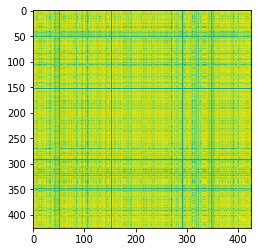

In [223]:
plt.imshow(x)

In [224]:
y = data_jp.values.astype(dtype=float)

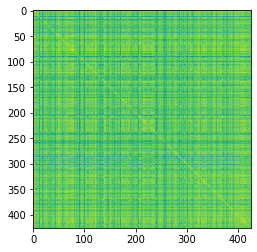

In [225]:
plt.imshow(y)

In [ ]:
#クラスタリングをしないと意味がない
# 生データを見続ける　sum等の要約をしない

In [226]:
!pip install seaborn


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 288.2/288.2 kB 5.9 MB/s eta 0:00:00


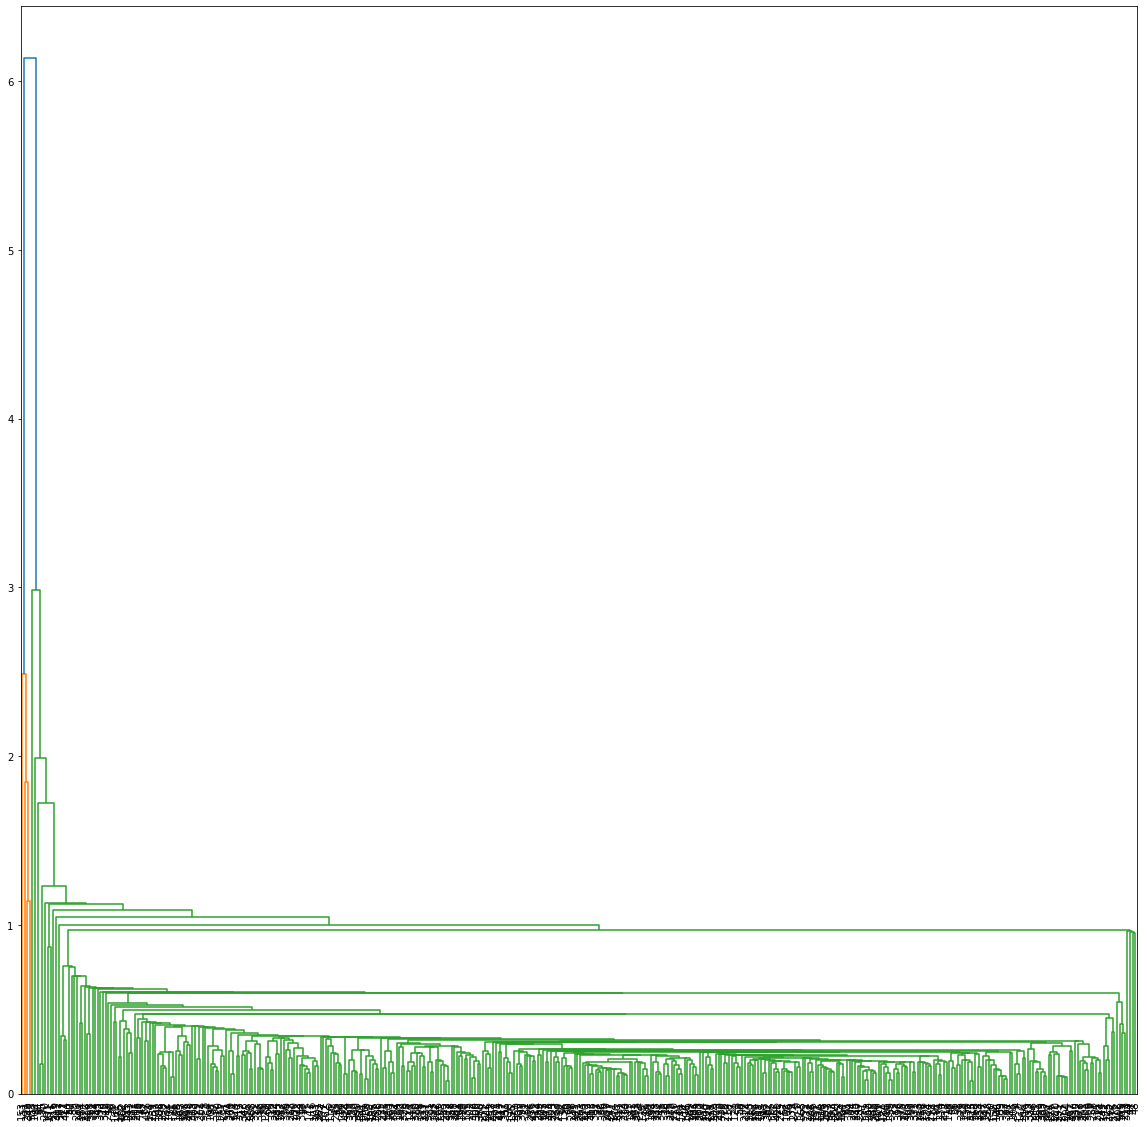

In [229]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
plt.figure(figsize=(20,20))
z = linkage(x, method='single', metric='euclid')
# dendrogram(z,labels=codelist)
dendrogram(z)
plt.tick_params(labelsize=10)

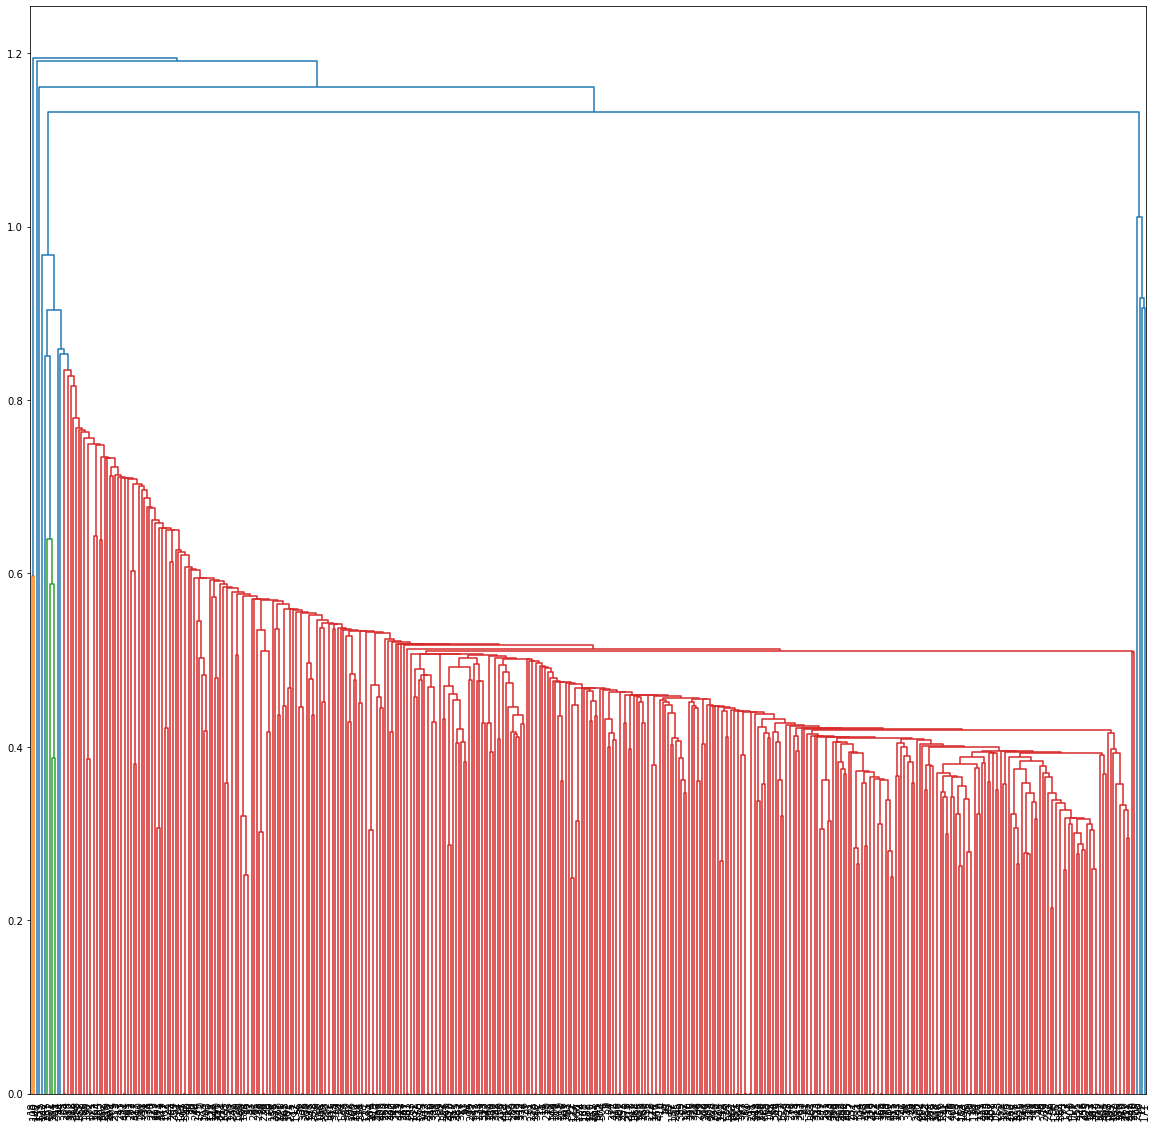

In [239]:
plt.figure(figsize=(20,20))
z = linkage(y, method='single', metric='euclid')
# dendrogram(z,labels=codelist)
dendrogram(z)
plt.tick_params(labelsize=10)

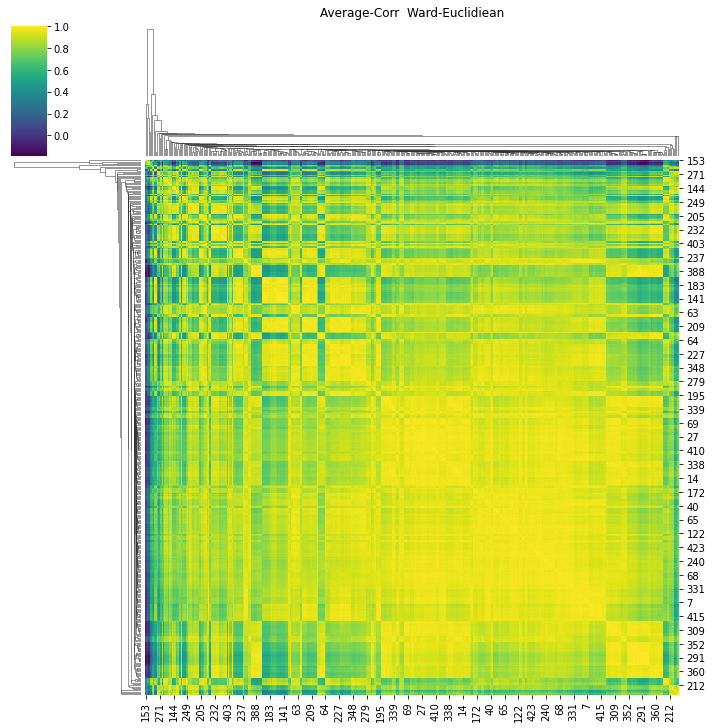

In [230]:
g = sns.clustermap(x, col_linkage=z, row_linkage=z,  cmap='viridis')
g.ax_col_dendrogram.set_title('Average-Corr  Ward-Euclidiean')
g.savefig('average-corr__ward-euclidean.png', dpi=150)
# 右端、左端を解釈

Text(0.5, 1.0, 'Average-Corr  Ward-Euclidiean')

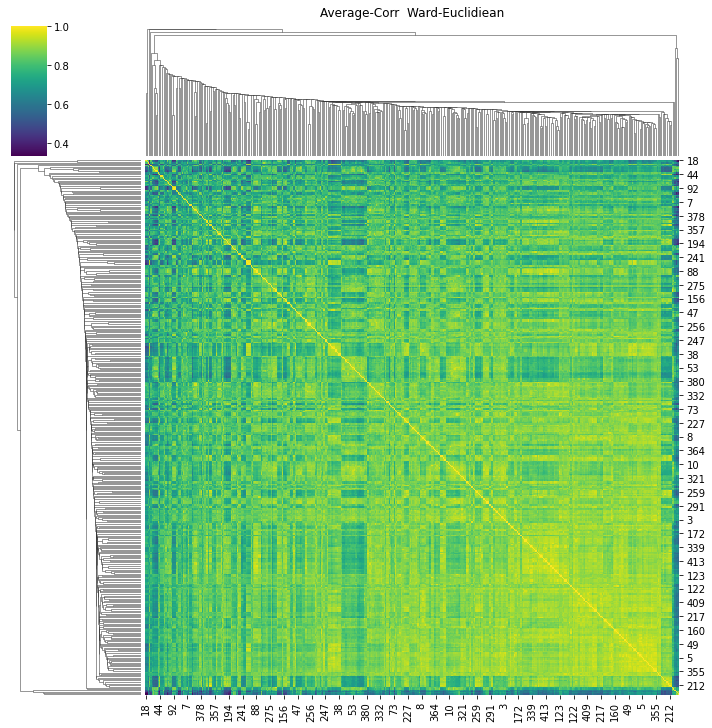

In [276]:
g = sns.clustermap(y, col_linkage=z, row_linkage=z,  cmap='viridis')
g.ax_col_dendrogram.set_title('Average-Corr  Ward-Euclidiean')
# g.savefig('average-corr__ward-euclidean.png', dpi=150)

In [206]:
data_jp

,Q208335 :Red Phalarope/ハイイロヒレアシシギ,Q206630 :Ortolan Bunting/ズアオホオジロ,Q266107 :Forest Wagtail/イワミセキレイ,Q200339 :Mandarin Duck/オシドリ,Q18851 :Little Ringed Plover/コチドリ,Q54696 :Eurasian Collared Dove/シラコバト,Q507383 :House Crow/イエガラス,Q174088 :Hawfinch/シメ,Q25334 :European Robin/ヨーロッパコマドリ,Q12265905 :Kamchatka leaf warbler/オオムシクイ,...,Q25984 :Western Yellow Wagtail/ツメナガセキレイ,Q46143 :Common Rosefinch/アカマシコ,Q27075672 :Ryukyu Robin/アカヒゲ,Q529048 :Black Scoter/クロガモ,Q1074291 :Chinese Bamboo Partridge/コジュケイ,Q18855 :Kentish Plover/シロチドリ,Q244035 :Least Auklet/コウミスズメ,Q716317 :Elegant Scops Owl/リュウキュウコノハズク,Q1268169 :Eastern Spot-billed Duck/カルガモ,Q862812 :White-crested Laughingthrush/ハクオウチョウ
0,1.0,0.901366,0.787955,0.722292,0.707367,0.789267,0.836676,0.62789,0.810168,0.751058,...,0.820278,0.865365,0.80362,0.745706,0.65049,0.829193,0.828683,0.896876,0.637214,0.809673
1,0.901366,1.0,0.867586,0.87485,0.825391,0.868757,0.869891,0.768214,0.881421,0.853459,...,0.888279,0.901743,0.90121,0.848186,0.77872,0.912491,0.902806,0.922234,0.723706,0.892128
2,0.787955,0.867586,1.0,0.893396,0.841161,0.945664,0.926627,0.778388,0.918473,0.88648,...,0.961414,0.76243,0.854134,0.823621,0.83934,0.902173,0.873242,0.860865,0.737673,0.952109
3,0.722292,0.87485,0.893396,1.0,0.914387,0.901642,0.837618,0.854081,0.907618,0.910293,...,0.856202,0.800761,0.89304,0.873059,0.888227,0.928221,0.861017,0.831993,0.800243,0.925761
4,0.707367,0.825391,0.841161,0.914387,1.0,0.838762,0.76318,0.875166,0.810201,0.870435,...,0.81161,0.780041,0.847698,0.894821,0.86848,0.845265,0.819918,0.828754,0.800093,0.851292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.829193,0.912491,0.902173,0.928221,0.845265,0.941795,0.902777,0.768807,0.944897,0.916698,...,0.900933,0.820005,0.899802,0.838934,0.80797,1.0,0.858992,0.872466,0.787375,0.934718
422,0.828683,0.902806,0.873242,0.861017,0.819918,0.86153,0.856572,0.840531,0.852458,0.816261,...,0.874647,0.878271,0.865212,0.860035,0.815455,0.858992,1.0,0.889796,0.740351,0.875506
423,0.896876,0.922234,0.860865,0.831993,0.828754,0.843426,0.840907,0.759782,0.843063,0.826149,...,0.894085,0.893964,0.856521,0.854123,0.768315,0.872466,0.889796,1.0,0.734885,0.877647
424,0.637214,0.723706,0.737673,0.800243,0.800093,0.797849,0.719746,0.763117,0.714694,0.788363,...,0.719247,0.730282,0.801902,0.841787,0.774358,0.787375,0.740351,0.734885,1.0,0.775557


In [207]:
data.to_csv('data_matrix/bert_en.csv')

In [208]:
data_jp.to_csv('data_matrix/bert_jp.csv')

## result_mean_vec

In [1]:
import json
with open('data_external/result_mean_vec.json', newline='',encoding="utf-8") as f:
    result_mean_vec = json.load(f)

In [18]:
import csv
all_BirdDBnode = []
with open('data_graph/all_BirdDBnode.tsv', newline='',encoding="utf-8") as f:
    reader = csv.DictReader(f,delimiter = '\t')
    for row in reader:
        all_BirdDBnode.append(row)

with_sound = []#all_BirdDBnodeのうち音情報のあるものだけ426
for d in all_BirdDBnode:
    if d["Research"] == "1" or d["JP"] == "1":
        with_sound.append(d)

#### 音声ベクトルデータ description項目をカタカナに統一

In [35]:
import unittest
from Romaji import Romaji

testcase = ["Hello","I'm","konnichiwa","砂糖","hecchara","ampamman"]
for t in testcase:
    print(t,Romaji.getKana(t))
    
result_mean = []#550
for d in result_mean_vec:
    try:
        dv_name = d_v["description"].split(" ")[1]
    except:
        dv_name = d_v["description"]
        dv_name = Romaji.getKana(dv_name)
    d["description_kana"] = dv_name
    result_mean.append(d["description"])

Hello Hエッォ
I'm I'ン
konnichiwa コンニチワ
砂糖 砂糖
hecchara ヘッチャラ
ampamman アンパンマン


In [6]:
print(result_mean,end =",")

['akaashishigi', 'akagera', 'akahara', 'akahige', 'akakokko', 'akamozu', 'ryuukyuuakashoubin', 'akashobin', 'amatsubame', 'amerikakoaji', 'aobato', 'aogera', 'aoji', 'aosagi', 'arisui', 'atori', 'ban', 'benihiwa', 'benimashiko', 'binzui', 'hashibosogarasu', 'bupposo', 'hashibutogara', 'chigohaya', 'chigomozu', 'chogenbo', 'chuhi', 'chushakushyigi', 'enaga', 'ezobitaki', 'ezomushikui', 'ezoraicho', 'ezorisu', 'ezosen', 'fukuro', 'gabicho', 'ginmuku', 'goisagi', 'gojyuukara', 'hagimashiko', 'hakkacho', 'hakusekirei', 'hamashigi', 'hashibutogarasu', 'hayabusa', 'hibari', 'hidorigamo', 'higara', 'higegabi', 'hikigaeru', 'hikuina', 'himeama', 'hirenjaku', 'hiyodori', 'hiyodorihina', 'hooaka', 'hoojiro', 'honsei', 'hototogisu', 'iijima', 'ikaru', 'isohiyodori', 'isoshigi', 'isuka', 'iwatsubame', 'jyoubitaki', 'juuichi', 'kaitsuburi', 'kajikagaeru', 'kakesu', 'kakko', 'kanmurikaitsuburi', 'kaogurogabi', 'kaojirogabityou', 'karafutomuji', 'karugamo', 'kashiradaka', 'kawagarasu', 'kawarahiwa', 

In [33]:
import unittest
from Romaji import Romaji

testcase = ["Hello","I'm","konnichiwa","砂糖","hecchara","ampamman"]
for t in testcase:
    print(t,Romaji.getKana(t))

Hello Hエッォ
I'm I'ン
konnichiwa コンニチワ
砂糖 砂糖
hecchara ヘッチャラ
ampamman アンパンマン


In [28]:
len(with_sound)

426

In [251]:
len(result_mean)

550

In [19]:
mean_vec_has_id = []
for d_w in with_sound:
    d_w["col"] = d_w["id"]+" :"+d_w["en_name"]+"/"+d_w["ja_name"]
    for d_v in result_mean_vec:
        en_name = d_w["BirdResearchDB_label01_32k_birdname"]
        jp_name = d_w["BirdJPBookDB__data_birdname"]
        try:
            dv_name = d_v["description"].split(" ")[1]
        except:
            dv_name = d_v["description"]
            
        if jp_name==dv_name or en_name==dv_name:
            d_w["description"] = d_v["description"]
            d_w["sound_vec"] = d_v["vector"]
            mean_vec_has_id.append(d_w)

In [20]:
len(mean_vec_has_id)

315

In [21]:
for d in mean_vec_has_id:
    print(d["description"])

72 ハイイロヒレアシシギ
46 ズアオホオジロ
48 オシドリ
43 コチドリ
34 イエガラス
14 シメ
39 ヨーロッパコマドリ
13 ウソ
05 アホウドリ
06 キマユムシクイ
61 ソリハシシギ
59 キアシシギ
55 コウラウン
25 クロヅル
16 ムギマキ
46 メダイチドリ
59 ユキホオジロ
49 トラツグミ
70 コゲラ
04 ツバメ
10 ギンザンマシコ
14 カワウ
33 カヤクグリ
35 カナダガン
58 ツグミ
17 サンカノゴイ
03 トビ
49 ハリオアマツバメ
30 カササギ
51 オカメインコ
51 マミジロ
50 オオトラツグミ
21 サメビタキ
56 クロジ
15 マダラヒタキ
09 ベニマシコ
79 キュウカンチョウ
18 シロアジサシ
59 ソウシチョウ
62 オグロシギ
25 オウチュウ
04 オオセグロカモメ
45 オオハクチョウ
49 マガモ
30 カササギ
55 ツルシギ
33 オーストンヤマガラ
64 ダイシャクシギ
23 ホシムクドリ
60 ウタツグミ
45 アオバズク
44 シラガホオジロ
20 エゾライチョウ
40 コノハズク
12 ベニアジサシ
01 ミサゴ
70 ウチヤマセンニュウ
71 セイタカシギ
50 カルガモ
15 タヒバリ
47 ハシグロヒタキ
19 ニュウナイスズメ
56 シロハラ
70 コゲチャキンパラ
71 セイタカシギ
15 カンムリワシ
40 ヒシクイ
42 コクチョウ
60 イソシギ
55 アカコッコ
23 ゴイサギ
40 ノゴマ
54 ノジコ
50 チョウショウバト
77 インドハッカ
51 ミヤマホオジロ
64 カエデチョウ
73 アカエリヒレアシシギ
09 コシジロウミツバメ
54 コンゴウインコ
12 ホオジロハクセキレイ
12 ホオジロハクセキレイ
53 クロウタドリ
65 クマゲラ
52 セキセイインコ
29 カワガラス
42 メグロ
31 ジュウイチ
71 シマキンパラ
11 センダイムシクイ
03 ショウドウツバメ
76 ホオジロムクドリ
39 カリガネ
01 コノドジロムシクイ
16 ハヤブサ
46 ノビタキ
20 シベリアムクドリ
67 ギンパラ
32 ヤンバルクイナ
42 コルリ
02 カイツブリ
22 コサメビタキ
01 ズアオアトリ
48 イソヒヨド

In [293]:
with_sound_has_vec = [d for d in with_sound if "sound_vec" in d]

In [298]:
for d in with_sound_has_vec:
    try:
        n = d["sound_vec"]
    except:
        print(d)

In [272]:
# with_sound[0]
# {'id': 'Q208335',
#  'en_name': 'Red Phalarope',
#  'ja_name': 'ハイイロヒレアシシギ',
#  'en_aliases': "{'0': 'Red Phalarope', '1': 'Grey Phalarope'}",
#  'ja_aliases': '{}',
#  'img_urls': "{'0': 'https://www.wikidata.org/wiki/Q208335#/media/File:Phalaropus%20fulicarius%2010.jpg', '1': 'https://www.wikidata.org/wiki/Q208335#/media/File:Grey%20Phalarope.jpg'}",
#  'taxon_rank': 'Q7432',
#  'taxon_name': 'Phalaropus fulicarius',
#  'parent_taxon': 'Q253776',
#  'BirdJPBookDB__data_audio_id': '2_72',
#  'BirdJPBookDB__data_birdname': 'ハイイロヒレアシシギ',
#  'BirdResearchDB_label01_32k_audio_id': '',
#  'BirdResearchDB_label01_32k_birdname': '',
#  'JP': '1',
#  'Research': '0',
#  'sound_vec': [-0.34293076395988464,
#   0.8081668019294739,

In [273]:
import numpy as np

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [303]:
col = [d["id"]+" :"+d["en_name"]+"/"+d["ja_name"] for d in with_sound_has_vec]

In [304]:
import pandas as pd
data_sound = pd.DataFrame(index=range(len(col)), columns=col)

In [305]:
for i in range(len(with_sound_has_vec)):
    d1 = with_sound_has_vec[i]
    for j in range(len(with_sound_has_vec)):
        d2 = with_sound_has_vec[j]
        c_s = cos_sim(d1["sound_vec"],d2["sound_vec"])
        data_sound.iat[i,j] = c_s
        data_sound.iat[j,i] = c_s

In [306]:
data_sound

,Q208335 :Red Phalarope/ハイイロヒレアシシギ,Q206630 :Ortolan Bunting/ズアオホオジロ,Q200339 :Mandarin Duck/オシドリ,Q18851 :Little Ringed Plover/コチドリ,Q507383 :House Crow/イエガラス,Q174088 :Hawfinch/シメ,Q25334 :European Robin/ヨーロッパコマドリ,Q25382 :Eurasian Bullfinch/ウソ,Q853412 :Short-tailed Albatross/アホウドリ,Q330318 :Yellow-browed Warbler/キマユムシクイ,...,Q27631965 :Larvivora akahige tanensis/タネコマドリ,Q18847 :Common Moorhen/バン,Q18865 :Pacific Golden Plover/ムナグロ,Q26892 :Ruddy Turnstone/キョウジョシギ,Q46143 :Common Rosefinch/アカマシコ,Q1074291 :Chinese Bamboo Partridge/コジュケイ,Q18855 :Kentish Plover/シロチドリ,Q716317 :Elegant Scops Owl/リュウキュウコノハズク,Q1268169 :Eastern Spot-billed Duck/カルガモ,Q862812 :White-crested Laughingthrush/ハクオウチョウ
0,1.0,0.940815,0.941723,0.941464,0.955919,0.958621,0.949426,0.985151,0.937809,0.957986,...,0.941657,0.952043,0.973861,0.937411,0.94499,0.959452,0.962175,0.940889,0.944444,0.918391
1,0.940815,1.0,0.998095,0.99818,0.993493,0.991746,0.994599,0.982924,0.998988,0.991448,...,0.998218,0.995781,0.984341,0.998689,0.997678,0.992183,0.989985,0.995955,0.996423,0.997339
2,0.941723,0.998095,1.0,0.998588,0.996518,0.995701,0.997626,0.983698,0.998228,0.995212,...,0.999312,0.99802,0.98756,0.999058,0.998379,0.995107,0.99426,0.997764,0.99594,0.996356
3,0.941464,0.99818,0.998588,1.0,0.996138,0.993593,0.995557,0.983284,0.998562,0.994154,...,0.998354,0.995933,0.984955,0.999526,0.99791,0.994089,0.991685,0.995279,0.99588,0.996109
4,0.955919,0.993493,0.996518,0.996138,1.0,0.997473,0.997304,0.990063,0.994219,0.999406,...,0.995782,0.997776,0.993378,0.994786,0.996143,0.996732,0.997253,0.993964,0.991279,0.988013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,0.959452,0.992183,0.995107,0.994089,0.996732,0.998936,0.998684,0.991371,0.991336,0.997517,...,0.995427,0.997355,0.995203,0.993422,0.997329,1.0,0.997756,0.995054,0.994799,0.98647
305,0.962175,0.989985,0.99426,0.991685,0.997253,0.999256,0.997626,0.991751,0.989903,0.998092,...,0.993696,0.997617,0.997677,0.991111,0.994427,0.997756,1.0,0.994746,0.991057,0.983494
306,0.940889,0.995955,0.997764,0.995279,0.993964,0.995597,0.997734,0.981574,0.995702,0.993099,...,0.998217,0.99825,0.989666,0.996616,0.997506,0.995054,0.994746,1.0,0.99721,0.994497
307,0.944444,0.996423,0.99594,0.99588,0.991279,0.993133,0.995183,0.982982,0.994861,0.99018,...,0.997155,0.995611,0.986768,0.996877,0.997252,0.994799,0.991057,0.99721,1.0,0.99369


In [307]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [309]:
x = data_sound.values.astype(dtype=float)

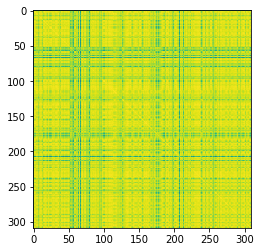

In [310]:
plt.imshow(x)

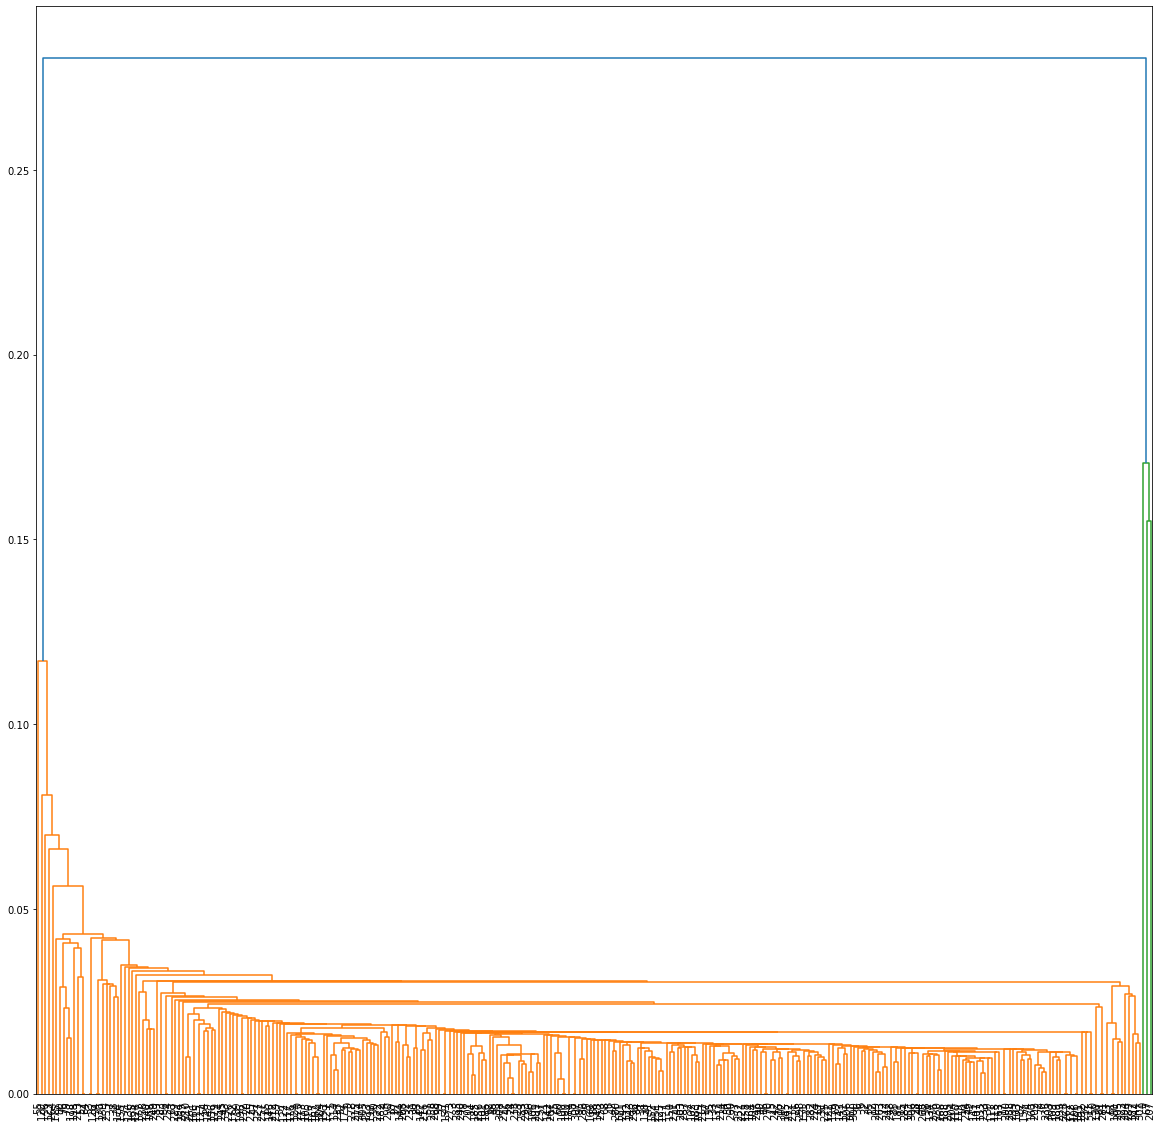

In [311]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
plt.figure(figsize=(20,20))
z = linkage(x, method='single', metric='euclid')
# dendrogram(z,labels=codelist)
dendrogram(z)
plt.tick_params(labelsize=10)

Text(0.5, 1.0, 'Average-Corr  Ward-Euclidiean')

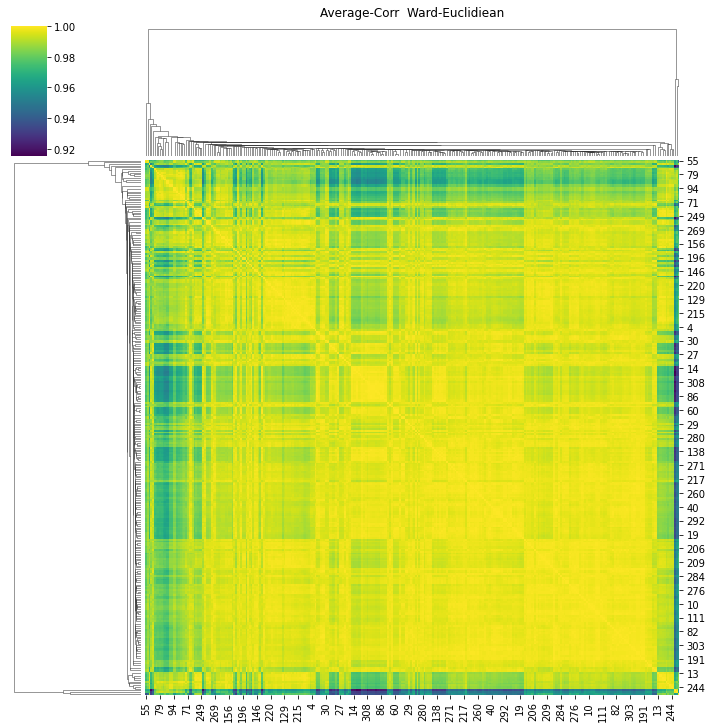

In [312]:
g = sns.clustermap(x, col_linkage=z, row_linkage=z,  cmap='viridis')
g.ax_col_dendrogram.set_title('Average-Corr  Ward-Euclidiean')
# g.savefig('average-corr__ward-euclidean.png', dpi=150)
# 右端、左端を解釈

In [313]:
data_sound.to_csv('data_matrix/sound.csv')